In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from celluloid import Camera

from setup import cleaned_arms_import_path, cleaned_countries_path

# I import pyarrow just to clarify that you need it installed
import pyarrow

In [14]:
if not os.path.isfile(cleaned_arms_import_path) or not os.path.isfile(cleaned_countries_path):
    print('Please first execute ./setup.py after decompressing .zip files')

arms_imports = pd.read_feather(cleaned_arms_import_path)
countries = pd.read_feather(cleaned_countries_path)

# Sources
* Arms imports data: [Kaggle](https://www.kaggle.com/datasets/justin2028/arms-imports-per-country)
* Countries and regions: [Kaggle](https://www.kaggle.com/datasets/fernandol/countries-of-the-world)


In [15]:
print('n countries in arms dataset: ', len(arms_imports.drop_duplicates(subset='country')))
arms_imports.head()

n countries in arms dataset:  261


,country,year,value,total_imports
0,Afghanistan,1950,0.0,16403.0
1,Afghanistan,1951,0.0,16403.0
2,Afghanistan,1952,0.0,16403.0
3,Afghanistan,1953,0.0,16403.0
4,Afghanistan,1954,0.0,16403.0


In [16]:
print('n_countries in countries dataset: ', len(countries))
countries.head()

n_countries in countries dataset:  227


,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),...,Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service,categorized_GDP
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0",...,"12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38",low GDP
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5",...,"21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579",low GDP
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0",...,"3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298",low GDP
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0",...,10,15,75,2,"22,46","3,27",None,None,None,low GDP
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0",...,"2,22",0,"97,78",3,"8,71","6,25",None,None,None,medium GDP


In [17]:
columns_from_countries_df = ['Country', 'Region', 'Population', 'GDP ($ per capita)', 'categorized_GDP', 'Literacy (%)', 'Birthrate', 'Deathrate']
renamed_cols_from_countries_df = {}
for col in columns_from_countries_df:
    renamed_cols_from_countries_df[col] = col.lower()

countries.rename(columns=renamed_cols_from_countries_df, inplace=True)

not_countries_arms_imports = arms_imports.copy(deep=True)[np.logical_not(arms_imports['country'].isin(countries['country']))]
not_countries_arms_imports.rename(columns={'country': 'region/organization'}, inplace=True)
not_countries_arms_imports.drop_duplicates(subset='region/organization').head()

,region/organization,year,value,total_imports
71,African Union**,1950,0.0,78.0
284,Amal (Lebanon)*,1950,0.0,60.0
355,ANC (South Africa)*,1950,0.0,0.0
497,Anti-Castro rebels (Cuba)*,1950,0.0,2.0
639,Armas (Guatemala)*,1950,0.0,8.0


In [18]:
to_merge = countries[renamed_cols_from_countries_df.values()]
arms_imports = arms_imports.merge(to_merge, on='country', validate='many_to_one')
arms_imports.head()

,country,year,value,total_imports,region,population,gdp ($ per capita),categorized_gdp,literacy (%),birthrate,deathrate
0,Afghanistan,1950,0.0,16403.0,ASIA (EX. NEAR EAST),31056997,700.0,low GDP,"36,0","46,6","20,34"
1,Afghanistan,1951,0.0,16403.0,ASIA (EX. NEAR EAST),31056997,700.0,low GDP,"36,0","46,6","20,34"
2,Afghanistan,1952,0.0,16403.0,ASIA (EX. NEAR EAST),31056997,700.0,low GDP,"36,0","46,6","20,34"
3,Afghanistan,1953,0.0,16403.0,ASIA (EX. NEAR EAST),31056997,700.0,low GDP,"36,0","46,6","20,34"
4,Afghanistan,1954,0.0,16403.0,ASIA (EX. NEAR EAST),31056997,700.0,low GDP,"36,0","46,6","20,34"


# Objective
## Get a general idea of recognized countries arms imports evolution

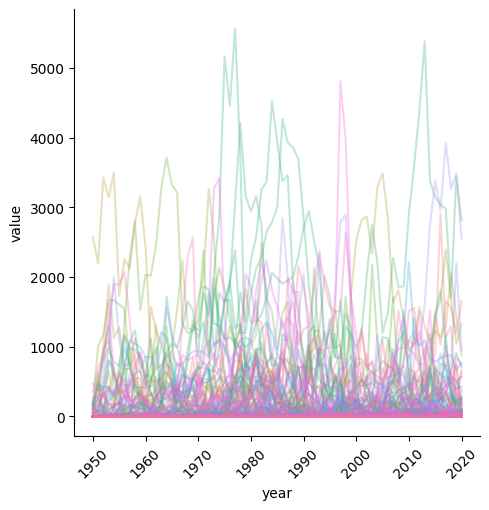

<Figure size 640x480 with 0 Axes>

In [19]:
sns.relplot(x='year', y='value', hue='country', data=arms_imports, kind='line', legend=None, alpha=.3)
x_ticks_year_step = 10
year_x_ticks = [year.__str__() for year in np.arange(1950, 2020 + x_ticks_year_step, x_ticks_year_step)]
plt.xticks(ticks=year_x_ticks, rotation=45)
plt.show()
plt.clf()

# Objective
## Track and name the recognized countries with the most total arms imports

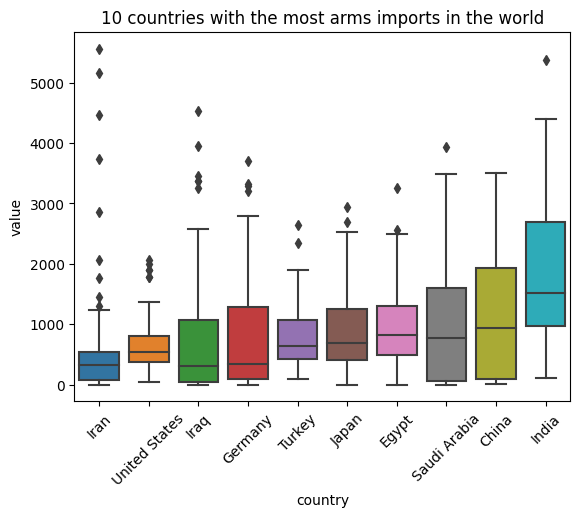

<Figure size 640x480 with 0 Axes>

In [20]:
track_count = 10
highest_total_arms_imports = arms_imports.drop_duplicates(subset=['country', 'total_imports']).nlargest(track_count, 'total_imports')

countries_with_highest_arms_imports_data = arms_imports[arms_imports['country'].isin(highest_total_arms_imports['country'])].sort_values(by='total_imports')

sns.boxplot(x='country', y='value', data=countries_with_highest_arms_imports_data)
plt.title(f'{track_count} countries with the most arms imports in the world')
plt.xticks(rotation=45)
plt.show()
plt.clf()

# Objective
## See wich recognized region has the highest total arms imports

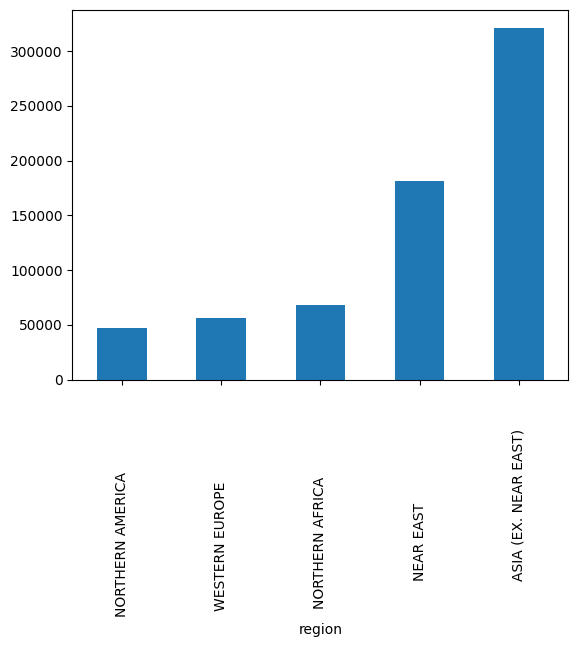

<Figure size 640x480 with 0 Axes>

In [21]:
total_arms_imports_per_region = highest_total_arms_imports.groupby('region')['total_imports'].sum().sort_values(ascending=True, inplace=False).plot(kind='bar')
plt.show()
plt.clf()

# Objective
## Does GDP affect the arms imports for recognised countries

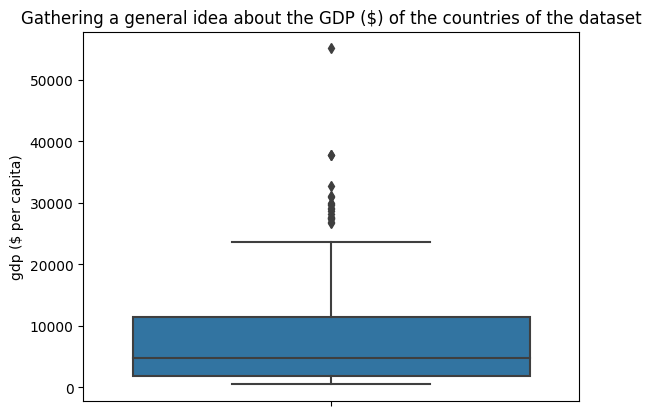

<Figure size 640x480 with 0 Axes>

In [22]:
sns.boxplot(y='gdp ($ per capita)', data=arms_imports.drop_duplicates(subset='country'))
plt.title('Gathering a general idea about the GDP ($) of the countries of the dataset')
plt.show()
plt.clf()

I categorized GDP by:
* Countries with less to 0$ of GDP as 'negative GDP'
* Countries with less than 15.000$ of GPD and more of 0$ as 'low GDP'
* Countries with more than 15.000$ of GDP but less than 27.000$ as 'medium GDP'
* Countries with more than 27.000$ of GDP as 'high GDP'
 
I note that GDP of countries is only based on present values

In [23]:
arms_imports.value_counts(subset='categorized_gdp')

categorized_gdp
low GDP       9159
high GDP      1207
medium GDP    1207
dtype: int64

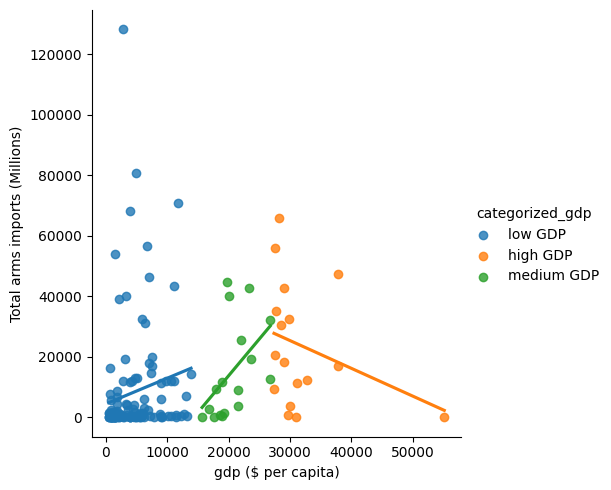

<Figure size 640x480 with 0 Axes>

In [24]:
sns.lmplot(x='gdp ($ per capita)', y='total_imports', hue='categorized_gdp', data=arms_imports.drop_duplicates('country'), ci=None)
plt.ylabel('Total arms imports (Millions)')
plt.show()
plt.clf()


### Results
* Low GDP countries:  There are more lower GDP per capita countries that haven't imported arms but also countries with the most arms imports are the ones with lower GDPS per capita, the one with the most arms imports is India.
 
* Mid-GDP countries:  There aren't much countries with a mid-GDP per capita that don't import arms, so, overall countries with more GDP tend to import more arms

* Trend:  As more GDP per capita a country has, more arms it imports